# GIAI ĐOẠN:  VECTORIZATION & TOPIC MODELING

<h3> VECTORIZATION: TF-IDF cho 4 mô hình ML (LDA, LSA, K-Means, HAC)

<H4> CÁC THƯ VIỆN CẦN THIẾT 

In [36]:
!pip install pandas numpy scikit-learn gensim pyLDAvis wordcloud matplotlib seaborn python-Levenshtein

<H4> SỬ DỤNG THƯ VIỆN

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
import os
warnings.filterwarnings('ignore') 

# Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer 

# Topic Modeling & Clustering
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering

# Visualization 
import pyLDAvis
import pyLDAvis.lda_model
from wordcloud import WordCloud

# Metrics
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.metrics import silhouette_score
import Levenshtein

## LOAD DỮ LIỆU 

#### CẤU HÌNH cho vector hoá và thống kê 

In [38]:
INPUT_CSV = r"C:\Users\ADMIN\python\NLP-final\Data\final_data.csv"
N_TOPICS = 15
N_TOP_WORDS = 15  # Số từ đại diện cho mỗi topic
RANDOM_STATE = 42

In [39]:
# Tạo thư mục TF-IDF
OUTPUT_DIR = r"C:\Users\ADMIN\python\NLP-final\Output\TF-IDF results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [40]:
df = pd.read_csv(INPUT_CSV)
print(f"✓ Đã load {len(df)} documents")
print(f"✓ Các cột: {list(df.columns)}")

✓ Đã load 2389 documents
✓ Các cột: ['description', 'category']


In [41]:
print(f"\nThống kê category:")
print(df['category'].value_counts())


Thống kê category:
category
Tin mới         1657
Xe               249
Thế giới          86
Pháp luật         80
Thời sự           72
Giải trí          59
Thể thao          51
Kinh doanh        35
Xã hội            24
Bóng đá           16
Giáo dục          13
Sức khỏe          10
Công nghệ          8
Chính trị          6
Văn hóa            5
Du lịch            5
Đời sống           4
Bất động sản       4
Số hóa             3
Khoa học           2
Name: count, dtype: int64


#### Sử dụng description để làm topic modeling

In [42]:
documents = df['description'].tolist()
print(f"\n✓ Sẽ dùng {len(documents)} documents cho topic modeling")


✓ Sẽ dùng 2389 documents cho topic modeling


## GIAI ĐOẠN: PHÂN TÍCH DỮ LIỆU KHÁM PHÁ (EDA)


[1] Phân tích Độ dài Tài liệu (Số lượng từ):
  • Độ dài TB: 215.17 từ
  • Độ dài Max: 519 từ
  • Độ dài Min: 20 từ


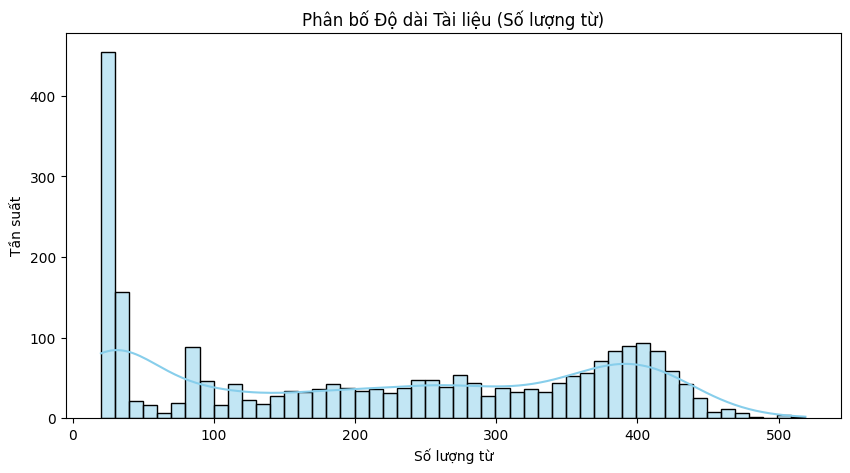

In [43]:
doc_lengths = [len(doc.split()) for doc in documents]

print("\n[1] Phân tích Độ dài Tài liệu (Số lượng từ):")
print(f"  • Độ dài TB: {np.mean(doc_lengths):.2f} từ")
print(f"  • Độ dài Max: {np.max(doc_lengths)} từ")
print(f"  • Độ dài Min: {np.min(doc_lengths)} từ")

plt.figure(figsize=(10, 5))
sns.histplot(doc_lengths, bins=50, kde=True, color='skyblue')
plt.title('Phân bố Độ dài Tài liệu (Số lượng từ)')
plt.xlabel('Số lượng từ')
plt.ylabel('Tần suất')
plt.savefig(os.path.join(OUTPUT_DIR, 'EDA_document_length_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()


[2] Phân tích Phân bố Category (Sự mất cân bằng):


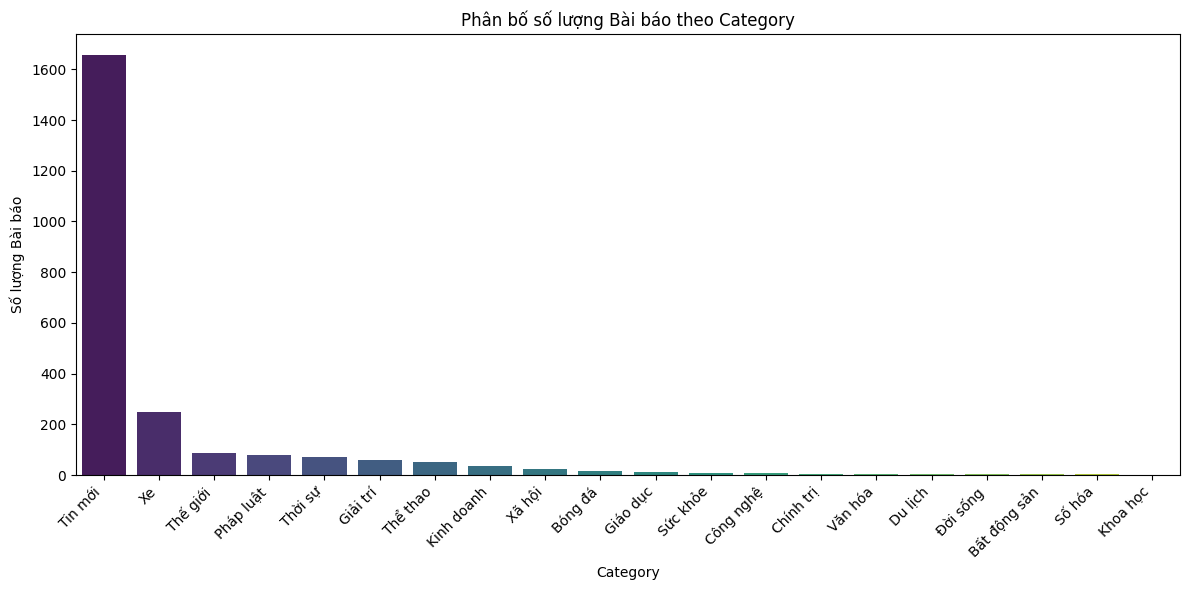

In [44]:
print("\n[2] Phân tích Phân bố Category (Sự mất cân bằng):")
category_counts = df['category'].value_counts()

plt.figure(figsize=(12, 6))
# Sử dụng Barplot để dễ dàng so sánh
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
plt.title('Phân bố số lượng Bài báo theo Category')
plt.xlabel('Category')
plt.ylabel('Số lượng Bài báo')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'EDA_category_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()


[3] Phân tích Tần suất Từ khóa (Top N-grams):


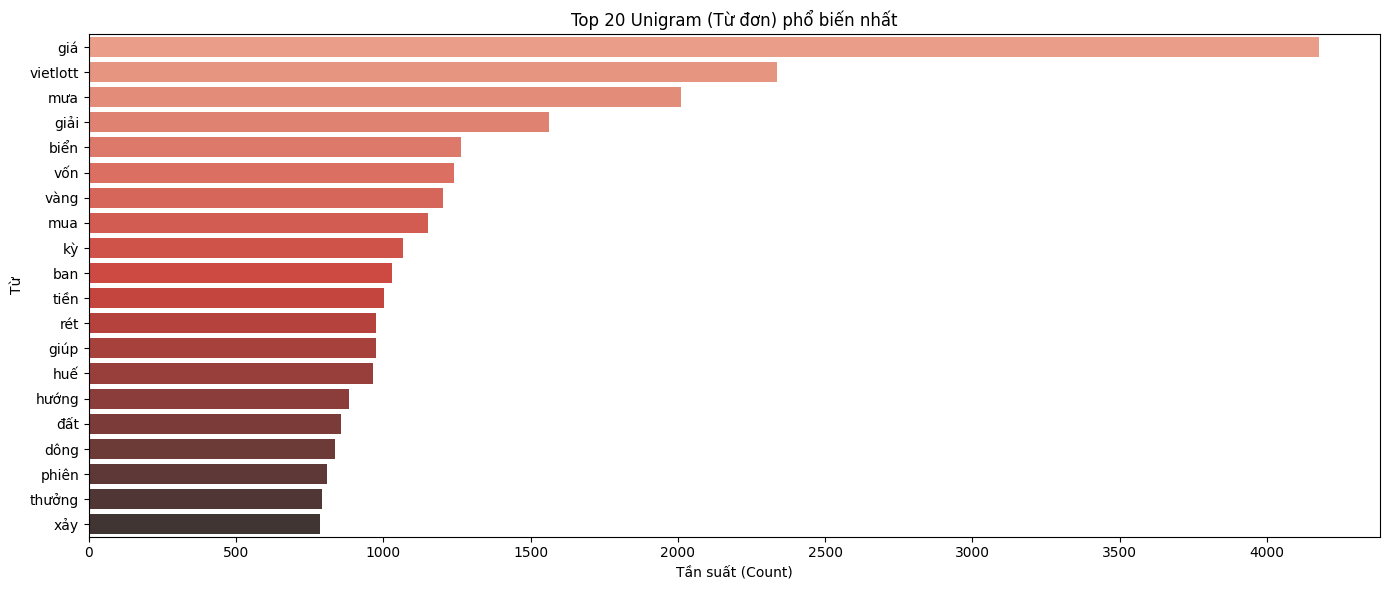

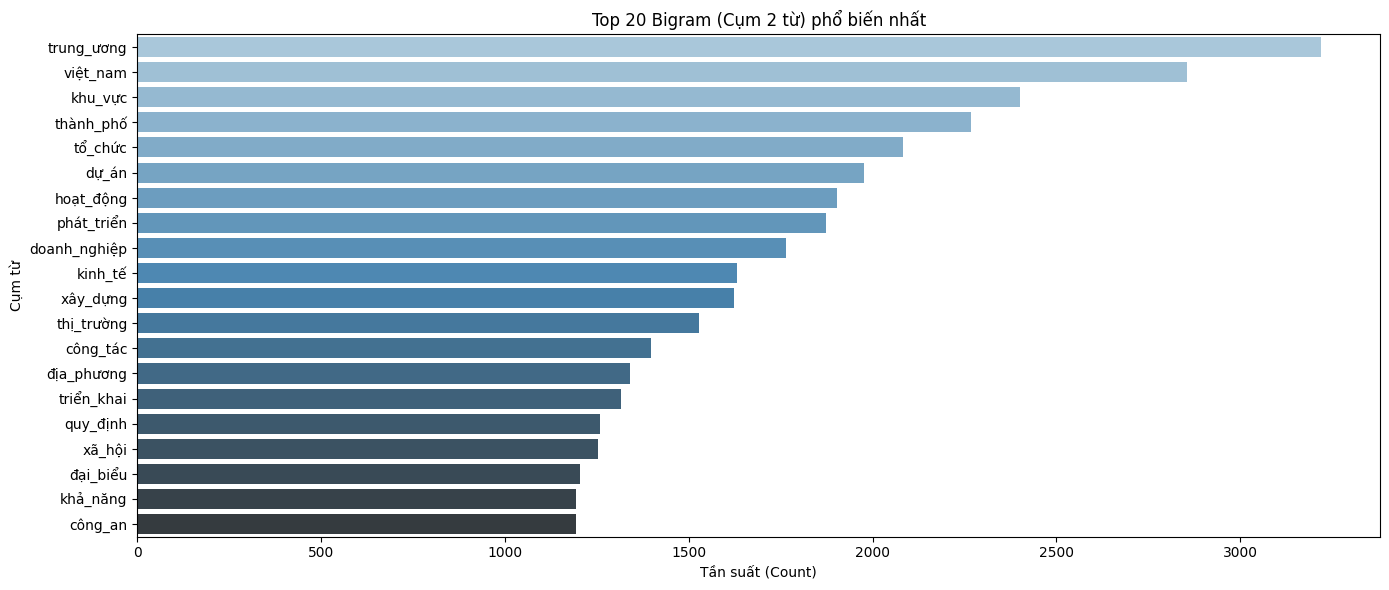

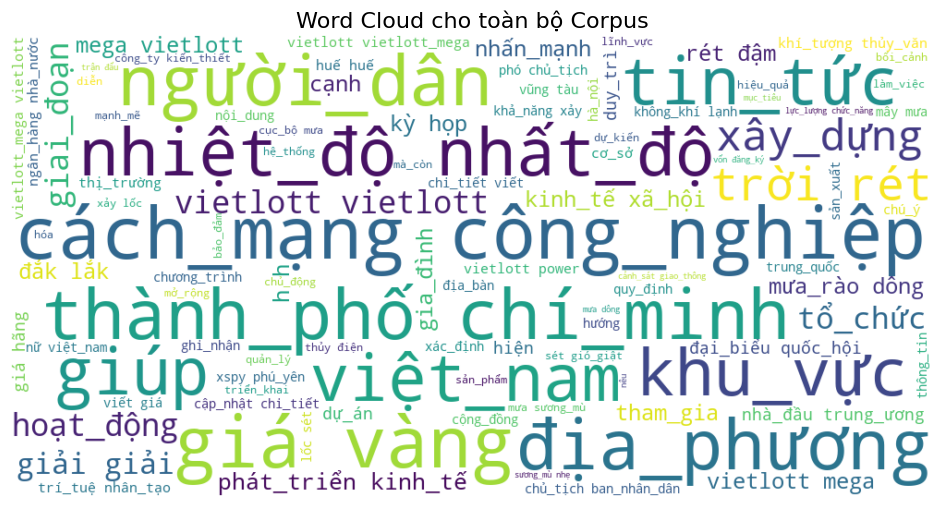

In [45]:
from sklearn.feature_extraction.text import CountVectorizer

print("\n[3] Phân tích Tần suất Từ khóa (Top N-grams):")


ngram_vectorizer = CountVectorizer(
    ngram_range=(1, 3), # Unigram, Bigram, Trigram
    max_features=10000  # Lấy 10000 features để phân tích top words thô
)
X = ngram_vectorizer.fit_transform(documents)
feature_names = ngram_vectorizer.get_feature_names_out()

# Tính tổng tần suất của mỗi từ/cụm từ
word_counts = X.sum(axis=0).A1
freq_df = pd.DataFrame({'word': feature_names, 'count': word_counts})
freq_df = freq_df.sort_values(by='count', ascending=False)

# Tinh lọc và hiển thị Top 20 Unigram và Bigram
top_unigrams = freq_df[freq_df['word'].apply(lambda x: len(x.split('_')) == 1)].head(20)
top_bigrams = freq_df[freq_df['word'].apply(lambda x: len(x.split('_')) == 2)].head(20)

plt.figure(figsize=(14, 6))
sns.barplot(x='count', y='word', data=top_unigrams, palette='Reds_d')
plt.title('Top 20 Unigram (Từ đơn) phổ biến nhất')
plt.xlabel('Tần suất (Count)')
plt.ylabel('Từ')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'EDA_top_unigrams.png'), dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(14, 6))
sns.barplot(x='count', y='word', data=top_bigrams, palette='Blues_d')
plt.title('Top 20 Bigram (Cụm 2 từ) phổ biến nhất')
plt.xlabel('Tần suất (Count)')
plt.ylabel('Cụm từ')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'EDA_top_bigrams.png'), dpi=300, bbox_inches='tight')
plt.show()

# Tạo Word Cloud cho toàn bộ dữ liệu
wordcloud_text = ' '.join(documents)
wordcloud = WordCloud(
    width=1000, height=500,
    background_color='white',
    colormap='viridis',
    max_words=100,
    contour_width=3,
).generate(wordcloud_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud cho toàn bộ Corpus', fontsize=16)
plt.savefig(os.path.join(OUTPUT_DIR, 'EDA_wordcloud_corpus.png'), dpi=300, bbox_inches='tight')
plt.show()

### VECTORIZATION - TF-IDF

In [46]:
# --- VECTORIZATION - TF-IDF Vectorizer (Sử dụng cho CẢ 4 models) ---
print("\n--- VECTORIZATION - TF-IDF Vectorizer ---")

vectorizer = TfidfVectorizer(
    max_features=5000,      # Giới hạn 5000 từ 
    min_df=5,               # Từ phải xuất hiện ít nhất 5 documents
    max_df=0.7,             # Từ không xuất hiện quá 70% documents
    ngram_range=(1, 2)      # Unigram và bigram
)
# doc_term_matrix sẽ là ma trận TF-IDF
doc_term_matrix = vectorizer.fit_transform(documents)
feature_names = vectorizer.get_feature_names_out()

print(f" Document-Term Matrix shape: {doc_term_matrix.shape}")
print(f"  - Số documents: {doc_term_matrix.shape[0]}")
print(f"  - Số features (từ): {doc_term_matrix.shape[1]}")
print(f"\n Sẽ dùng TF-IDF matrix này cho CẢ 4 models: LDA, LSA, K-Means, HAC")
print(f" Ví dụ features: {list(feature_names[:10])}")


--- VECTORIZATION - TF-IDF Vectorizer ---
 Document-Term Matrix shape: (2389, 5000)
  - Số documents: 2389
  - Số features (từ): 5000

 Sẽ dùng TF-IDF matrix này cho CẢ 4 models: LDA, LSA, K-Means, HAC
 Ví dụ features: ['a_bank', 'air', 'album', 'an_giang', 'an_khánh', 'an_ninh', 'an_ninh mạng', 'an_ninh quốc_gia', 'an_ninh trật_tự', 'an_ninh điều_tra']


In [47]:
# Lấy feature names
feature_names = vectorizer.get_feature_names_out()
print(f"\n Ví dụ features: {list(feature_names[:20])}")


 Ví dụ features: ['a_bank', 'air', 'album', 'an_giang', 'an_khánh', 'an_ninh', 'an_ninh mạng', 'an_ninh quốc_gia', 'an_ninh trật_tự', 'an_ninh điều_tra', 'an_ninh_mạng', 'an_ninh_mạng phòng_chống', 'an_ninh_mạng quốc_gia', 'an_sinh', 'an_sinh xã_hội', 'an_toàn', 'an_toàn chạy_tàu', 'an_toàn công_trình', 'an_toàn giao_thông', 'an_toàn thực_phẩm']


## XÂY DỰNG 4 MODELS (LDA, LSA, K-Means, HAC)

In [48]:
# XÂY DỰNG 4 MODELS
models = {}
doc_topic_distributions = {}

### MODEL 1: LDA (Latent Dirichlet Allocation)

In [49]:
print("\n[4.1] Training LDA Model (using TF-IDF matrix)...")
lda_model = LatentDirichletAllocation(
    n_components=N_TOPICS,
    max_iter=50,
    learning_method='online',
    random_state=RANDOM_STATE,
    batch_size=128,
    n_jobs=-1,
    verbose=0
)
lda_output = lda_model.fit_transform(doc_term_matrix) 
models['LDA'] = lda_model
doc_topic_distributions['LDA'] = lda_output
print(f"LDA trained - Perplexity: {lda_model.perplexity(doc_term_matrix):.2f}")


[4.1] Training LDA Model (using TF-IDF matrix)...
LDA trained - Perplexity: 9317.45


### MODEL 2: LSA (Latent Semantic Analysis / Truncated SVD)

In [50]:
print("\n[4.2] Training LSA Model (using TF-IDF matrix)...")
lsa_model = TruncatedSVD(
    n_components=N_TOPICS,
    algorithm='randomized',
    n_iter=100,
    random_state=RANDOM_STATE
)
lsa_output = lsa_model.fit_transform(doc_term_matrix)
models['LSA'] = lsa_model
doc_topic_distributions['LSA'] = lsa_output

# Normalize LSA output to get pseudo-probabilities
lsa_output_normalized = np.abs(lsa_output)
lsa_output_normalized = lsa_output_normalized / lsa_output_normalized.sum(axis=1, keepdims=True)
doc_topic_distributions['LSA'] = lsa_output_normalized

explained_var = lsa_model.explained_variance_ratio_.sum()
print(f"✓ LSA trained - Explained variance: {explained_var*100:.2f}%")


[4.2] Training LSA Model (using TF-IDF matrix)...
✓ LSA trained - Explained variance: 18.02%


### MODEL 3: K-Means

In [51]:
print("\n[4.3] Training K-Means Model (using TF-IDF matrix)...")
kmeans_model = KMeans(
    n_clusters=N_TOPICS,
    init='k-means++',
    max_iter=300,
    n_init=10,
    random_state=RANDOM_STATE
)
kmeans_labels = kmeans_model.fit_predict(doc_term_matrix) 
models['KMeans'] = kmeans_model

# Tạo pseudo document-topic distribution từ distances
kmeans_distances = kmeans_model.transform(doc_term_matrix)
kmeans_probs = 1 / (1 + kmeans_distances)
kmeans_probs = kmeans_probs / kmeans_probs.sum(axis=1, keepdims=True)
doc_topic_distributions['KMeans'] = kmeans_probs
print(f"✓ K-Means trained - Inertia: {kmeans_model.inertia_:.2f}")


[4.3] Training K-Means Model (using TF-IDF matrix)...
✓ K-Means trained - Inertia: 1996.29


### MODEL 4: HAC (Hierarchical Agglomerative Clustering)

In [52]:
print("\n[4.4] Training HAC Model (using TF-IDF matrix)...")
hac_model = AgglomerativeClustering(
    n_clusters=N_TOPICS,
    metric='cosine',
    linkage='average'
)
# HAC cần numpy array, nên ta dùng .toarray()
hac_labels = hac_model.fit_predict(doc_term_matrix.toarray()) 
models['HAC'] = hac_model

# Tạo pseudo distribution cho HAC (one-hot encoding)
hac_probs = np.zeros((len(hac_labels), N_TOPICS))
hac_probs[np.arange(len(hac_labels)), hac_labels] = 1
doc_topic_distributions['HAC'] = hac_probs
print(f"✓ HAC trained")


[4.4] Training HAC Model (using TF-IDF matrix)...
✓ HAC trained


## BƯỚC 4: TRÍCH XUẤT TOP WORDS CHO MỖI MODEL

In [53]:
def get_top_words_from_components(components, feature_names, n_top_words):
    """Lấy top words từ component matrix (LDA/LSA)"""
    topics_words = []
    for topic_idx, topic in enumerate(components):
        top_indices = topic.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_indices]
        topics_words.append(top_words)
    return topics_words

def get_top_words_from_centroids(model, feature_names, n_top_words):
    """Lấy top words từ cluster centroids (K-Means)"""
    topics_words = []
    for centroid in model.cluster_centers_:
        top_indices = centroid.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_indices]
        topics_words.append(top_words)
    return topics_words

def get_top_words_from_labels(matrix, labels, feature_names, n_clusters, n_top_words):
    """Lấy top words từ labels (HAC)"""
    topics_words = []
    
    for cluster_id in range(n_clusters):
        cluster_docs = matrix[labels == cluster_id]
        if cluster_docs.shape[0] > 0: 
            # Tính trung bình TF-IDF trong cluster
            # .A1 là để chuyển sparse matrix mean sang numpy array 1D
            centroid = cluster_docs.mean(axis=0).A1 
            top_indices = centroid.argsort()[-n_top_words:][::-1]
            top_words = [feature_names[i] for i in top_indices]
            topics_words.append(top_words)
        else:
            topics_words.append([])
    
    return topics_words

# Trích xuất top words
all_topics_words = {}

# 1. LDA
all_topics_words['LDA'] = get_top_words_from_components(
    lda_model.components_, feature_names, N_TOP_WORDS
)

# 2. LSA
all_topics_words['LSA'] = get_top_words_from_components(
    lsa_model.components_, feature_names, N_TOP_WORDS
)

# 3. K-Means
all_topics_words['KMeans'] = get_top_words_from_centroids(
    kmeans_model, feature_names, N_TOP_WORDS
)

# 4. HAC
all_topics_words['HAC'] = get_top_words_from_labels(
    doc_term_matrix, hac_labels, feature_names, N_TOPICS, N_TOP_WORDS
)

# In kết quả (Ví dụ)
for model_name, topics_words in all_topics_words.items():
    print(f"\n[5.{list(all_topics_words.keys()).index(model_name)+1}] {model_name} Top Words (dựa trên TF-IDF):")
    for idx, words in enumerate(topics_words):
        print(f"  Topic {idx}: {', '.join(words[:8])}")


[5.1] LDA Top Words (dựa trên TF-IDF):
  Topic 0: công_an, cảnh_sát, đối_tượng, vi_phạm, án, giao_thông, lực_lượng, vụ
  Topic 1: xuất_hành, kiện_tụng, cưới_hỏi, dương_lịch, kỵ, lịch_âm, dương_lịch rơi, xuất_hành hướng
  Topic 2: ùn_tắc, giao_thông, hắc_đạo, ùn_tắc giao_thông, hà_nội, xuất_hành, đường_sắt, tin_tức
  Topic 3: vietlott, chủ_nhật, xspy, huế, phú_yên, giải, xstth, kon_tum
  Topic 4: giá, hãng, cập_nhật, giá hãng, dòng, chi_tiết, ô_tô, mẫu
  Topic 5: biên_phòng, tàu, hải_quân, bộ_đội biên_phòng, bộ_đội, đà_nẵng, thuốc_lá, pháo_hoa
  Topic 6: rùa, trú, thả, loài, trình_báo, môi_trường sống, tự_nhiên, tự_nguyện
  Topic 7: xspy, tuấn, xuất_hành, chủ_nhật, bình_định, kiện_tụng, phú_yên, cưới_hỏi
  Topic 8: điều_khiển, cảnh_sát, đội cảnh_sát, cảnh_sát giao_thông, điều_khiển mô_tô, clip, sinh ngụ, hành_vi
  Topic 9: tin_tức, tử_vong, tóc, đối_tượng, thủy_sản, vàng, tin_tức tin_tức, lưu_trữ
  Topic 10: lũ, xả, thủy điện, xả lũ, mưa, thiên_tai, khắc_phục, thủy
  Topic 11: mưa, rét

## BƯỚC 5: SINH CAPTION CHO MỖI TOPIC (4 MODELS)

In [54]:
def generate_topic_caption(top_words, top_n=3):
    """Sinh caption tự động"""
    caption_words = [w.replace('_', ' ') for w in top_words[:top_n]]
    return ' + '.join(caption_words).title()

all_captions = {}

for model_name, topics_words in all_topics_words.items():
    print(f"\n[5.{list(all_topics_words.keys()).index(model_name)+1}] {model_name} Captions:")
    captions = {}
    for idx, words in enumerate(topics_words):
        caption = generate_topic_caption(words, top_n=3)
        captions[idx] = caption
        print(f"  Topic {idx}: {caption}")
    all_captions[model_name] = captions


[5.1] LDA Captions:
  Topic 0: Công An + Cảnh Sát + Đối Tượng
  Topic 1: Xuất Hành + Kiện Tụng + Cưới Hỏi
  Topic 2: Ùn Tắc + Giao Thông + Hắc Đạo
  Topic 3: Vietlott + Chủ Nhật + Xspy
  Topic 4: Giá + Hãng + Cập Nhật
  Topic 5: Biên Phòng + Tàu + Hải Quân
  Topic 6: Rùa + Trú + Thả
  Topic 7: Xspy + Tuấn + Xuất Hành
  Topic 8: Điều Khiển + Cảnh Sát + Đội Cảnh Sát
  Topic 9: Tin Tức + Tử Vong + Tóc
  Topic 10: Lũ + Xả + Thủy Điện
  Topic 11: Mưa + Rét + Không Khí
  Topic 12: Cục Trưởng + Chống + Bị Cáo
  Topic 13: Tin Tức + Trung Ương + Việt Nam
  Topic 14: Động Đất + Sóng Thần + Trận Động Đất

[5.2] LSA Captions:
  Topic 0: Vietlott + Chủ Nhật + Xspy
  Topic 1: Trung Ương + Giá + Dự Án
  Topic 2: Mưa + Rét + Nhiệt Độ
  Topic 3: Giá + Vàng + Giá Vàng
  Topic 4: Vietlott + Vietlott Vietlott + Power
  Topic 5: Trận + Nữ + Philippines
  Topic 6: Giải + Thưởng + Cập Nhật
  Topic 7: Giải + Vàng + Thưởng
  Topic 8: Giải + Thưởng + Đại Biểu
  Topic 9: Doanh Nghiệp + Đăng Ký + Vốn
  Topic 10:

## BƯỚC 6: GÁN TOPIC/CLUSTER CHO MỖI DOCUMENT

In [55]:
df['topic_LDA'] = lda_output.argmax(axis=1)
df['topic_prob_LDA'] = lda_output.max(axis=1)

In [56]:
df['topic_LSA'] = lsa_output_normalized.argmax(axis=1)
df['topic_prob_LSA'] = lsa_output_normalized.max(axis=1)

In [57]:
df['topic_KMeans'] = kmeans_labels
df['topic_prob_KMeans'] = kmeans_probs.max(axis=1)

In [58]:
df['topic_HAC'] = hac_labels
df['topic_prob_HAC'] = 1.0  # HAC là hard clustering

In [59]:
for model_name in ['LDA', 'LSA', 'KMeans', 'HAC']:
    print(f"\n{model_name} - Phân bố documents:")
    print(df[f'topic_{model_name}'].value_counts().sort_index())


LDA - Phân bố documents:
topic_LDA
0      120
3      241
4       88
5       21
10      45
11     153
13    1721
Name: count, dtype: int64

LSA - Phân bố documents:
topic_LSA
0     114
1     879
2     122
3     227
4      48
5     121
6      23
7      37
8     196
9      39
10     68
11     52
12    289
13     92
14     82
Name: count, dtype: int64

KMeans - Phân bố documents:
topic_KMeans
0      69
1      98
2     248
3      81
4      81
5     326
6      97
7      63
8     132
9     225
10     54
11    145
12     26
13     70
14    674
Name: count, dtype: int64

HAC - Phân bố documents:
topic_HAC
0      15
1     186
2     684
3     340
4     112
5      38
6      97
7     238
8      31
9      38
10    358
11      1
12    216
13     27
14      8
Name: count, dtype: int64


## BƯỚC 7: ĐÁNH GIÁ CHẤT LƯỢNG - 4 MODELS

In [60]:
def calculate_compactness_cosine(doc_vectors, labels):
    """Compactness - Cosine distance"""
    unique_labels = np.unique(labels)
    compactness_scores = []
    
    for label in unique_labels:
        cluster_docs = doc_vectors[labels == label]
        if len(cluster_docs) > 1:
            cos_dist = cosine_distances(cluster_docs)
            n = len(cluster_docs)
            avg_dist = (cos_dist.sum() - n) / (n * (n - 1))
            compactness_scores.append(avg_dist)
    
    return np.mean(compactness_scores)

def calculate_separation_cosine(doc_vectors, labels):
    """Separation - Cosine distance"""
    unique_labels = np.unique(labels)
    centroids = []
    
    for label in unique_labels:
        cluster_docs = doc_vectors[labels == label]
        centroid = cluster_docs.mean(axis=0)
        centroids.append(centroid)
    
    centroids = np.array(centroids)
    cos_dist = cosine_distances(centroids)
    n_clusters = len(unique_labels)
    avg_separation = (cos_dist.sum() - n_clusters) / (n_clusters * (n_clusters - 1))
    
    return avg_separation

In [61]:
# Tính metrics cho tất cả models
evaluation_results = []

In [62]:
for model_name in ['LDA', 'LSA', 'KMeans', 'HAC']:
    print(f"\n[7.{['LDA', 'LSA', 'KMeans', 'HAC'].index(model_name)+1}] Evaluating {model_name}...")
    
    doc_vectors = doc_topic_distributions[model_name]
    labels = df[f'topic_{model_name}'].values
    
    # Compactness
    compactness = calculate_compactness_cosine(doc_vectors, labels)
    
    # Separation
    separation = calculate_separation_cosine(doc_vectors, labels)
    
    # Silhouette Score
    silhouette = silhouette_score(doc_vectors, labels, metric='cosine')
    
    # Levenshtein
    captions = [all_captions[model_name][i] for i in range(N_TOPICS)]
    lev_distances = []
    for i in range(len(captions)):
        for j in range(i+1, len(captions)):
            lev_distances.append(Levenshtein.distance(captions[i], captions[j]))
    avg_lev = np.mean(lev_distances) if lev_distances else 0
    
    evaluation_results.append({
        'Model': model_name,
        'Compactness_Cosine': compactness,
        'Separation_Cosine': separation,
        'Silhouette_Cosine': silhouette,
        'Avg_Levenshtein': avg_lev
    })
    
    print(f"  ✓ Compactness: {compactness:.4f}")
    print(f"  ✓ Separation: {separation:.4f}")
    print(f"  ✓ Silhouette: {silhouette:.4f}")
    print(f"  ✓ Levenshtein: {avg_lev:.2f}")
    


[7.1] Evaluating LDA...


  ✓ Compactness: 0.0459
  ✓ Separation: 0.6696
  ✓ Silhouette: 0.8833
  ✓ Levenshtein: 21.83

[7.2] Evaluating LSA...
  ✓ Compactness: 0.0821
  ✓ Separation: 0.4549
  ✓ Silhouette: 0.3726
  ✓ Levenshtein: 21.62

[7.3] Evaluating KMeans...
  ✓ Compactness: -0.0116
  ✓ Separation: -0.0679
  ✓ Silhouette: 0.5034
  ✓ Levenshtein: 24.78

[7.4] Evaluating HAC...
  ✓ Compactness: -0.0272
  ✓ Separation: 0.9286
  ✓ Silhouette: 0.9996
  ✓ Levenshtein: 20.13


In [63]:
# Tạo DataFrame so sánh
eval_df = pd.DataFrame(evaluation_results)
print("\n" + "="*80)
print("📊 BẢNG SO SÁNH 4 MODELS:")
print("="*80)
print(eval_df.to_string(index=False))

# Lưu file
eval_df.to_csv(os.path.join(OUTPUT_DIR, 'comparison_all_models.csv'), index=False)
print(f"\n✓ Đã lưu: {os.path.join(OUTPUT_DIR, 'comparison_all_models.csv')}")


📊 BẢNG SO SÁNH 4 MODELS:
 Model  Compactness_Cosine  Separation_Cosine  Silhouette_Cosine  Avg_Levenshtein
   LDA            0.045894           0.669596           0.883333        21.828571
   LSA            0.082146           0.454902           0.372633        21.619048
KMeans           -0.011624          -0.067878           0.503412        24.780952
   HAC           -0.027218           0.928571           0.999581        20.133333

✓ Đã lưu: C:\Users\ADMIN\python\NLP-final\Output\TF-IDF results\comparison_all_models.csv


## BƯỚC 8: TRỰC QUAN HÓA - WORDCLOUD CHO 4 MODELS

In [64]:
def create_wordcloud_for_model(model_name, topics_words, n_topics):
    """Tạo WordCloud cho 1 model"""
    n_cols = 2
    n_rows = (n_topics + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    axes = axes.flatten() if n_topics > 1 else [axes]
    
    for idx in range(n_topics):
        # Tạo word frequency dict
        words = topics_words[idx]
        word_freq = {word: len(words) - i for i, word in enumerate(words)}
        
        wordcloud = WordCloud(
            width=800, height=400,
            background_color='white',
            colormap='viridis',
            max_words=50
        ).generate_from_frequencies(word_freq)
        
        axes[idx].imshow(wordcloud, interpolation='bilinear')
        axes[idx].set_title(f'Topic {idx}: {all_captions[model_name][idx]}', 
                           fontsize=12, fontweight='bold')
        axes[idx].axis('off')
    
    for idx in range(n_topics, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(f'{model_name} - WordClouds', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f'wordclouds_{model_name}.png'), dpi=300, bbox_inches='tight')
    print(f"✓ Đã lưu: {os.path.join(OUTPUT_DIR, f'wordclouds_{model_name}.png')}")
    plt.close()

In [65]:
for model_name in ['LDA', 'LSA', 'KMeans', 'HAC']:
    print(f"\n[8.{['LDA', 'LSA', 'KMeans', 'HAC'].index(model_name)+1}] Tạo WordCloud cho {model_name}...")
    create_wordcloud_for_model(model_name, all_topics_words[model_name], N_TOPICS)


[8.1] Tạo WordCloud cho LDA...
✓ Đã lưu: C:\Users\ADMIN\python\NLP-final\Output\TF-IDF results\wordclouds_LDA.png

[8.2] Tạo WordCloud cho LSA...
✓ Đã lưu: C:\Users\ADMIN\python\NLP-final\Output\TF-IDF results\wordclouds_LSA.png

[8.3] Tạo WordCloud cho KMeans...
✓ Đã lưu: C:\Users\ADMIN\python\NLP-final\Output\TF-IDF results\wordclouds_KMeans.png

[8.4] Tạo WordCloud cho HAC...
✓ Đã lưu: C:\Users\ADMIN\python\NLP-final\Output\TF-IDF results\wordclouds_HAC.png


## BƯỚC 9: pyLDAvis (CHỈ CHO LDA)

In [70]:
print("Đang tạo pyLDAvis...")
vis_data = pyLDAvis.lda_model.prepare(
    lda_model, 
    doc_term_matrix, 
    vectorizer,
    mds='mmds',  # Thay vì 'pcoa'
    sort_topics=False
)
output_path = os.path.join(OUTPUT_DIR, 'lda_visualization_mmds.html')
pyLDAvis.save_html(vis_data, output_path)
print(f"✓ Đã lưu: {output_path}")

Đang tạo pyLDAvis...
✓ Đã lưu: C:\Users\ADMIN\python\NLP-final\Output\TF-IDF results\lda_visualization_mmds.html


## BƯỚC 10: SO SÁNH TRỰC QUAN

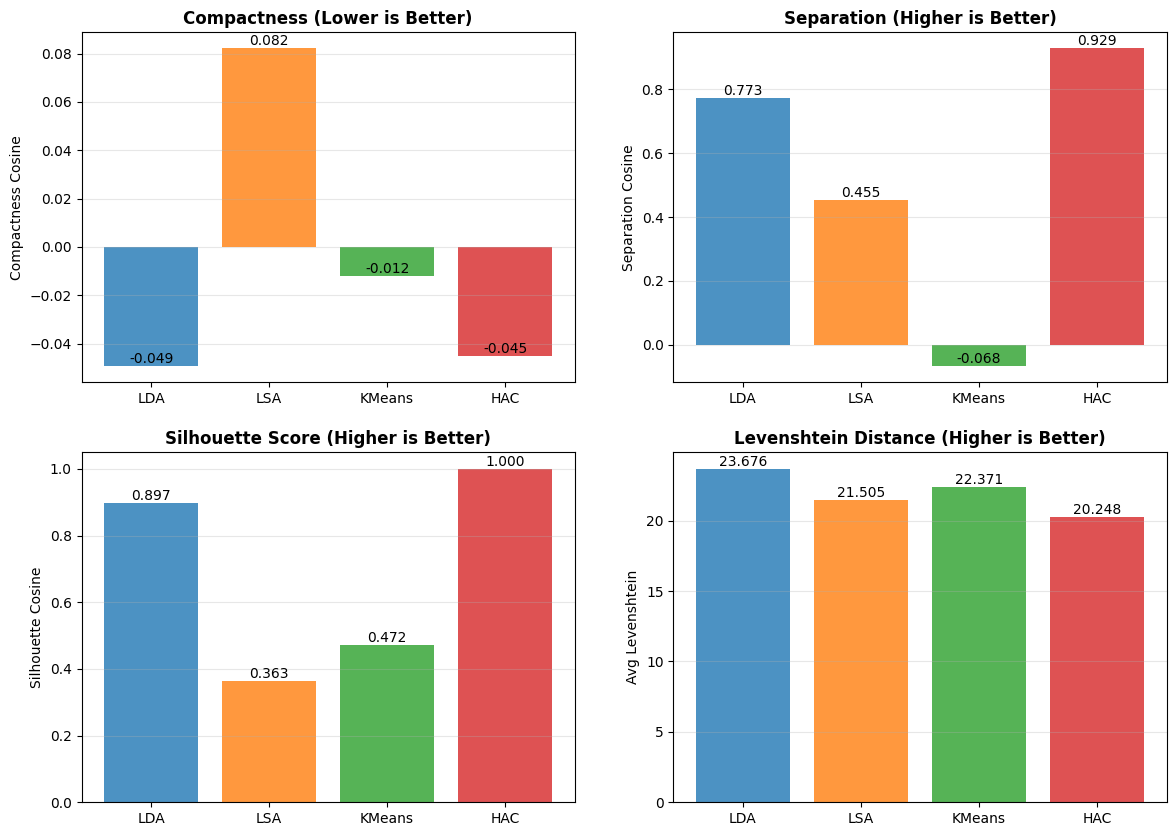

In [ ]:
# Bar chart comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Compactness_Cosine', 'Separation_Cosine', 'Silhouette_Cosine', 'Avg_Levenshtein']
titles = ['Compactness (Lower is Better)', 'Separation (Higher is Better)', 
          'Silhouette Score (Higher is Better)', 'Levenshtein Distance (Higher is Better)']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    bars = ax.bar(eval_df['Model'], eval_df[metric], color=colors, alpha=0.8)
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylabel(metric.replace('_', ' '))
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10)

In [ ]:
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR,'comparison_metrics_chart.png'), dpi=300, bbox_inches='tight')
print(f"Đã lưu: {os.path.join(OUTPUT_DIR, 'comparison_metrics_chart.png')}")
plt.show()

✓ Đã lưu: comparison_metrics_chart.png


<Figure size 640x480 with 0 Axes>

In [ ]:
def generate_smart_caption(top_words):
    """
    Tạo caption tự động từ 3 từ khóa hàng đầu.
    Ví dụ: ['giá_vàng', 'tăng', 'mạnh'] -> "GIÁ_VÀNG - TĂNG - MẠNH"
    """
    # Lấy 3 từ đầu tiên, viết hoa và nối bằng dấu gạch ngang
    return " - ".join([word.upper() for word in top_words[:3]])

smart_captions = {}

# 1. Tạo Caption cho từng Topic của từng Model
for model_name in ['LDA', 'LSA', 'KMeans', 'HAC']:
    smart_captions[model_name] = {}
    print(f"\n Generating Captions for {model_name}:")
    
    for idx, words in enumerate(all_topics_words[model_name]):
        # Gọi hàm tạo caption
        caption = generate_smart_caption(words)
        smart_captions[model_name][idx] = caption
        print(f"  Topic {idx}: {caption}")

# 2. Cập nhật Caption vào DataFrame chính (df)
# Mapping topic ID sang Caption
df['caption_LDA'] = df['topic_LDA'].map(smart_captions['LDA'])
df['caption_LSA'] = df['topic_LSA'].map(smart_captions['LSA'])
df['caption_KMeans'] = df['topic_KMeans'].map(smart_captions['KMeans'])
df['caption_HAC'] = df['topic_HAC'].map(smart_captions['HAC'])

# 3. Lưu file dữ liệu đầy đủ (bao gồm cả Caption mới)
output_final_csv = os.path.join(OUTPUT_DIR, 'final_data_tfidf_with_captions.csv')
df.to_csv(os.path.join(OUTPUT_DIR, output_final_csv), index=False, encoding='utf-8-sig')
print(f"\n✓ Đã lưu file dữ liệu đầy đủ: {output_final_csv}")

# 4. Tạo và Lưu file Summary cho từng Model (Quan trọng để so sánh)
print("\n📝 Đang tạo file Summary cho từng model...")

for model_name in ['LDA', 'LSA', 'KMeans', 'HAC']:
    summary_data = []
    
    for idx in range(N_TOPICS):
        # Đếm số lượng bài báo thuộc topic này
        topic_col = f'topic_{model_name}'
        n_docs = (df[topic_col] == idx).sum()
        
        # Lấy top words dạng chuỗi
        top_words_str = ', '.join(all_topics_words[model_name][idx][:10])
        
        summary_data.append({
            'Topic_ID': idx,
            'Caption': smart_captions[model_name][idx], # Cột này file BoW có
            'Top_Words': top_words_str,
            'Num_Documents': n_docs,
            'Percentage': f"{(n_docs/len(df))*100:.2f}%"
        })
    
    # Tạo DataFrame và lưu
    summary_df = pd.DataFrame(summary_data)
    output_path = os.path.join(OUTPUT_DIR, f'topic_summary_{model_name}_tfidf.csv')
    summary_df.to_csv(output_path, index=False, encoding='utf-8-sig')
    print(f" Đã lưu: {output_path}")

print("\nHOÀN THÀNH TOÀN BỘ QUÁ TRÌNH (TF-IDF)!")


🏷️  Generating Captions for LDA:
  Topic 0: DOANH_NGHIỆP - LỪA_ĐẢO - CAMPUCHIA
  Topic 1: MITSUBISHI - ROVER - SPORT
  Topic 2: ĐƯỜNG_SẮT - TRUNG_KHOA - LÊ TRUNG_KHOA
  Topic 3: VIETLOTT - CHỦ_NHẬT - XSPY
  Topic 4: CROSS - TIGUAN - TERAMONT
  Topic 5: LEXUS - LX - NX
  Topic 6: HẢI_QUÂN - TÀU - ĐÀ_NẴNG
  Topic 7: XUẤT_HÀNH - HOÀNG_ĐẠO - HẮC_ĐẠO
  Topic 8: CÔNG_AN VIỆN_KIỂM_SÁT - TỒN_KHO - NHÀ_ĐẦU
  Topic 9: BÉ GÁI - TIN_TỨC - BIỂN
  Topic 10: GIẢI - THƯỞNG - TRẬN
  Topic 11: MƯA - RÉT - NHIỆT_ĐỘ
  Topic 12: LƯU_TRỮ - RÙA - THẢ
  Topic 13: TIN_TỨC - GIÁ - TRUNG_ƯƠNG
  Topic 14: PORSCHE - HÃNG PORSCHE - PANAMERA

🏷️  Generating Captions for LSA:
  Topic 0: VIETLOTT - CHỦ_NHẬT - XSPY
  Topic 1: TRUNG_ƯƠNG - GIÁ - DỰ_ÁN
  Topic 2: MƯA - RÉT - NHIỆT_ĐỘ
  Topic 3: GIÁ - VÀNG - GIÁ VÀNG
  Topic 4: VIETLOTT - VIETLOTT VIETLOTT - POWER
  Topic 5: TRẬN - NỮ - PHILIPPINES
  Topic 6: GIẢI - THƯỞNG - CẬP_NHẬT
  Topic 7: GIẢI - VÀNG - THƯỞNG
  Topic 8: GIẢI - THƯỞNG - ĐẠI_BIỂU
  Topic 9: DOANH_NGH